In [1]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf
import os ,sys, platform
import time
import cosmopower as cp
import multiprocessing
from multiprocessing import Pool
import threading

In [2]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [5]:
def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0): #Function for CAMb
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None  
    return cambq 

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi

def Cosmo_Power(DET,omb,omc,h,tau,ns,As): #function for single value cosmopower
   
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    return Para,pred,chi #parameter, prediction , chi value

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def for_cosmo(DET,DEF,range,para):
    #finding the fitted value for single values
    pred_arr=[]
    chi_arr=[]
    if DEF=='omb':
        for val in range:
            des = Cosmo_Power(DET,val,para[1],para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])            
    elif DEF=='omc':
        for val in range:
            des = Cosmo_Power(DET,para[0],val,para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='h':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],val,para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='tau':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],val,para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='ns':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],val,para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='as':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],para[4],val)
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    else:
        Print("check DATA type. ERROR!")
        
    fitted_val = Find_val(range,chi_arr)
    return fitted_val #returns best fitted value with chi2

def iter_pars(DET,rang,para):
    #function to iterate each parameters by setting all initial parameter and runnning each time and setting the parameter
    omb = for_cosmo(DET,'omb',rang[0],para)
    para[0] = omb
    omc = for_cosmo(DET,'omc',rang[1],para)
    para[1] = omc
    h = for_cosmo(DET,'h',rang[2],para)
    para[2] = h
    tau = for_cosmo(DET,'tau',rang[3],para)
    para[3] = tau
    ns = for_cosmo(DET,'ns',rang[4],para)
    para[4] = ns
    As = for_cosmo(DET,'as',rang[5],para)
    para[5] = As
    para = [omb,omc,h,tau,ns,As]
    return para # return parameter
    
def loop_it(DET,rang,paras,tims):
    #this function finding parameters for several 'times', finding errors for each parameters
    omb = []
    omc = []
    h = []
    tau = []
    ns = []
    As = []
    for i in range(tims):
        para = iter_pars(DET,rang,paras)
        omb.append(para[0])
        omc.append(para[1])
        h.append(para[2])
        tau.append(para[3])
        ns.append(para[4])
        As.append(para[5])

    omb_error = np.std(omb)
    omc_error = np.std(omc)
    h_error = np.std(h)
    tau_error = np.std(tau)
    ns_error = np.std(ns)
    As_error = np.std(As)
    para_error = [omb_error,omc_error,h_error,tau_error,ns_error,As_error ]
    para = [np.average(omb),np.average(omc),np.average(h),np.average(tau),np.average(ns),np.average(As)]
    #returning prameters and its errors which is standard deviations
    return para,para_error
#double parameters functions
def cosmopo(DET,par_arr,da='none',db='none'): #cosmopower for a array of values
    pre = []
    chi = []
    arr = []
    for par in par_arr: #iterating each parameters in the array
        set =  Cosmo_Power(DET,par[0],par[1],par[2],par[3],par[4],par[5])
        set_pre = set[1]
        set_chi = set[2]
        pre.append(set_pre)
        chi.append(set_chi)
        arr.append([par[0],par[1],par[2],par[3],par[4],par[5],da,db,set_chi])
    fit_par = Find_val(par_arr,chi) #finding the best fitted parameters from the array
    return fit_par,arr

def par_arr(DEF,rang,par): #for creating array of parameters for one set of range
    arr = []
    for i in rang:
        if DEF == 'omb':
            arr.append([i,par[1],par[2],par[3],par[4],par[5]])
        elif DEF == 'omc':
            arr.append([par[0],i,par[2],par[3],par[4],par[5]])
        elif DEF == 'h':
            arr.append([par[0],par[1],i,par[3],par[4],par[5]])
        elif DEF == 'tau':
            arr.append([par[0],par[1],par[2],i,par[4],par[5]])
        elif DEF == 'ns':
            arr.append([par[0],par[1],par[2],par[3],i,par[5]])
        elif DEF == 'as':
            arr.append([par[0],par[1],par[2],par[3],par[4],i])
        else :
            print('check input par')

    return arr #returns only a arrray

def par_arr_2(DEF1,DEF2,rang1,rang2,par): #creating array of parameters for 2 sets of ranges
    arr = []
    first_arr = par_arr(DEF1,rang1,par)#initial single array creation
    for i in first_arr: 
        for j in rang2:
            if DEF2 == 'omb':
                arr.append([j,i[1],i[2],i[3],i[4],i[5]])
            elif DEF2 == 'omc':
                arr.append([i[0],j,i[2],i[3],i[4],i[5]])
            elif DEF2 == 'h':
                arr.append([i[0],i[1],j,i[3],i[4],i[5]])
            elif DEF2 == 'tau':
                arr.append([i[0],i[1],i[2],j,i[4],i[5]])
            elif DEF2 == 'ns':
                arr.append([i[0],i[1],i[2],i[3],j,i[5]])
            elif DEF2 == 'as':
                arr.append([i[0],i[1],i[2],i[3],i[4],j])
            else:
                print("check")

    return arr,DEF1,DEF2 #returns the array rang1*rang2 and parameter1 and 2

def cospor(DET,i,pars_arr,ran_arr,par,ret_arr=False): #for simple Calculation inputs are Data type,iteration number,parameter name array, range array,parameter
    pars = ["omb","omc","h","tau","ns","as"]
    da = pars_arr[i][0] #getting parameter name 1
    db = pars_arr[i][1] #getting parameter name 2
    Ra1 = ran_arr[pars.index(da)] # range of parameter1 
    Ra2 = ran_arr[pars.index(db)] # range of parameter2
    arr = par_arr_2(da,db,Ra1,Ra2,par)[0] #array generation 
    parm = cosmopo(DET,arr,da,db) #Cosmopowers on array
    arr = parm[1]
    rev = [parm[0],da,db] #fitted parameters for given range i
    np.save('likeliyhood/chi_arr/'+da+'_'+db,parm[1])
    if ret_arr==True:
        return rev,arr
    else:
        return rev

def cospors(rang_arr,par,par_arr = None,plot = False,thread = False):
    pars = ["omb","omc","h","tau","ns","as"]
    pars_arr = []
    #array generation with parameters names it also as rules that [a,a] does not exist,[a,b] or [a,b] pairs repeat once
    if par_arr == None:
        for xi in pars:
            for yi in pars:
                if xi == yi:
                    pass
                else:
                    pars_arr.append([xi,yi])

        for xi in pars:
            for yi in pars:
                for ys in pars_arr:
                    if [xi,yi]==ys:
                        pars_arr.remove([yi,xi])
                    else:
                        pass
    else:
        pars_arr = par_arr
        
    threads = [] #multithreading for fast calculations
    par_ar = [] 
    par_a = []#this is the results parameters stored

    for i in range(len(pars_arr)): # number of calculations
        if thread == False: #Direct calculations without threading
            par_a.append(cospor('TT',i,pars_arr,rang_arr,par)) #value stored as[[parameters],name of par1,2]
        else:
            t = threading.Thread(target=lambda i=i: par_ar.append(cospor("TT",i,pars_arr,rang_arr,par,True))) #multithreading parameters
            threads.append(t) #saving the threads
            t.start() #start threads  
            
            for t in threads: # for join threads at closing
                t.join() # on joining no threads is in order

    print_arr = []
    plot_arr = []
    if thread == True:
        for i in par_ar:
            par_a.append(i[0])
            plot_arr.append(i[1])

    if plot == True:
        for i in plot_arr:
            arrar = []
            xy = []
            yy = []
            z = []
            da = i[0][6]
            db = i[0][7]
            for j in i:
                da = j[6]
                db = j[7]
                chi = j[8]
                xi = j[pars.index(da)]
                yi = j[pars.index(db)]
                arrar.append([xi,yi,chi])
            print_arr.append([da,db,arrar])
            np.save('likeliyhood/plot_arr/'+da+'_'+db,arrar)
            plotif(arrar,da,db)
        
    runs =[par_a , print_arr]
    return runs#[[parameters],name of parameter1 and parameter2] in a list

def de_par(par_aa,prints=False): #for finding average and standard deviation of given parameters
    pars = ["omb","omc","h","tau","ns","as"]
    par = [[],[],[],[],[],[]]
    for i in par_aa:
        par[pars.index(i[1])].append(i[0][pars.index(i[1])])
        par[pars.index(i[2])].append(i[0][pars.index(i[2])])
    pam = [[],[],[],[],[],[]]
    rev =[]
    for i in range(len(pars)):
        pam[i].append([pars[i],[np.average(par[i])],[np.std(par[i])]])
    
    for i in pam:
        if prints == True:
            print(i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10))
        else:
            rev.append([i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10)])    
    return rev #list(parameters:value +- standard deviation)

def plotif(arri,da,db,drae = False):
    d = [[],[],[]]
    for j in range(len(arri)):
        d[0].append(arri[j][0])
        d[1].append(arri[j][1])
        d[2].append(arri[j][2])

    e = [np.unique(d[0]),np.unique(d[1]),np.rot90(np.reshape(d[2],(np.shape(np.unique(d[0]))[0],np.shape(np.unique(d[1]))[0])))]
    extent = (np.min(e[0]),np.max(e[0]),np.min(e[1]),np.max(e[1]))
    f = np.log(e[2])
    dd =[da,db]
    if drae ==False:
        par_1 = e[0][np.argmin(np.nanmean(f,axis = 0))]
        par_2 = e[1][np.argmin(np.nanmean(f,axis = 1))]
        plt.axhline(par_1)
        plt.axvline(par_2)
        plt.xlabel(da)
        plt.ylabel(db)
        plt.imshow(f,aspect='auto',cmap=plt.cm.Spectral,extent= extent)
        plt.colorbar()
        plt.show()
    else: 
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
        '''deltachi_1 = np.max(e[2]) - 2*np.log(np.mean(e[2],axis=0))
        deltachi_2 = np.max(e[2]) - 2*np.log(np.mean(e[2],axis=1))
        '''
        #plt.plot(e[1],np.log(np.mean(e[2],axis=1)),xlabel=db,ylabel='chi_sq')
    
        deltachi_1=np.log(np.mean(e[2],axis=0))/np.min(np.log(np.mean(e[2],axis=0)))
        deltachi_2=np.log(np.mean(e[2],axis=1))/np.min(np.log(np.mean(e[2],axis=1)))
        ax1.plot(e[0],deltachi_1)
        ax1.set_xlabel(dd[0])
        ax2.set_xlabel(dd[1])
        ax1.set_ylabel('chi_sq')
        ax2.set_ylabel('chi_sq')
        

        ax2.plot(e[1],deltachi_2)
        plt.show()
        print('Resulted Values')
        for i in range(2):

            s = np.mean(e[2],axis=i)/np.min(np.mean(e[2],axis=i))
            eff = 1.01
            es = []
            ess = []
            for l in range(len(e[i])):
                if s[l] > eff:
                    es.append(0)
                elif s[l] <= eff:
                    es.append(e[i][l])
                    ess.append(e[i][l])
            er = [np.min(ess),np.average(ess),np.max(ess)]
            error = np.std(er)

            
            print(dd[i],':',d[i][np.argmin(np.mean(e[2],axis=i))],'+_',error)
        
    return e
    #plt.plot(e[1],np.log(np.mean(e[2],axis=1)),xlabel=db,ylabel='chi_sq')
    


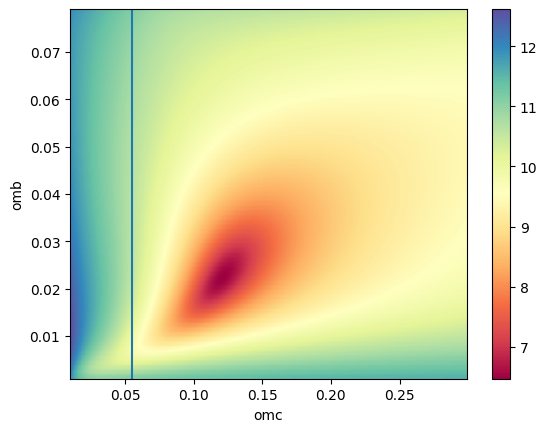

completed in  2 min 1s 81 ms : [[[0.022000000000000002, 0.1209999999999999, 67.282, 0.05355, 0.9667, 2.0961], 'omc', 'omb']]
Total Time Taken :  2 min 1s 81 ms


In [6]:
#Double parameter method
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.001,0.08,0.001)
omc = np.arange(0.01,0.3,0.001)
h = np.arange(50,90,0.1)
tau = np.arange(0.0001,0.2,0.001)
ns = np.arange(0.5,1.5,0.01)
As = np.arange(1.5,2.5,0.001)
rangee = [omb,omc,h,tau,ns,As]

#paras = [0.0221,0.1205,67.29,0.0542,0.945,2.0969]
#paras = [0.02228,0.12056,66.956,0.05098,0.96868,2.1094]
paras = [0.022271,0.1211,67.282,0.05355,0.9667,2.0961]
st = time.time()
pars_aray = [['omc','omb'],]
'''
             ['h','omb'],  ['h','omc'],['ns','tau'],['as','tau'],
             ['tau','omb'],['tau','omc'],
             ['ns','omb'], ['ns','omc'], ['ns','h'], ['ns','tau'],
             ['as','omb'], ['as','omc'], ['as','h'], ['as','tau'],['as','ns']]'''
par_ar1 = cospors(rangee,paras,pars_aray,True,True)
print('completed in ',time_hr(time.time()-st),':',par_ar1[0])
et = time.time()
print('Total Time Taken : ',time_hr(et-st))

In [ ]:
# to find mean of parameters
pars = ["omb","omc","h","tau","ns","as"]
par = [[],[],[],[],[],[]]
for i in par_ar1:
    par[pars.index(i[1])].append(i[0][pars.index(i[1])])
    par[pars.index(i[2])].append(i[0][pars.index(i[2])])
    #print(i[1],":",i[0][pars.index(i[1])],i[2],":",i[0][pars.index(i[2])])
pam = [[],[],[],[],[],[]]
for i in range(len(pars)):
    pam[i].append([pars[i],[np.average(par[i])],[np.std(par[i])]])
for i in pam:
    print(i[0][0],':',np.round(i[0][1],5),'+-',np.round(i[0][2],10))
    